In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'


In [2]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_path as path
from pathlib import Path
from PIL import Image
import torch
import pytorch_lightning as pl

import xarray
import xrspatial.multispectral as ms

import math

from cloud_seg.utils import chip_vis

DATA_DIR = Path.cwd().parent.resolve() / "data/"
DATA_DIR_CLOUDS = DATA_DIR / 'clouds/'
DATA_DIR_CLOUDLESS = DATA_DIR / 'cloudless/'
DATA_DIR_CLOUDLESS_MOST_SIMILAR = DATA_DIR / 'cloudless_most_similar/'
DATA_DIR_CLOUDLESS_TIF = DATA_DIR / 'cloudless_tif/'
DATA_DIR_OUT = DATA_DIR / "model_training/"

PREDICTION_DIR = Path.cwd().parent.resolve() / "trained_models/unet/4band_originaldata_efficientnet-b0_dice__Normalize_VerticalFlip_HorizontalFlip_RandomRotate90/predictions/"

TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_FEATURES_NEW = DATA_DIR / "train_features_new"

TRAIN_LABELS = DATA_DIR / "train_labels"

BANDS = ["B02", "B03", "B04", "B08"]
BANDS_NEW = []
# BANDS_NEW = ["B01", "B11"]

assert TRAIN_FEATURES.exists(), TRAIN_LABELS.exists()


def get_array(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return im_arr

def to_xarray(im_arr):
    """Put images in xarray.DataArray format"""

    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(img):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    
    red = to_xarray(img[2])
    green = to_xarray(img[1])
    blue = to_xarray(img[0])
    
    return ms.true_color(r=red, g=green, b=blue)

    
def load_image(chip_id, bands=["B02", "B03", "B04", "B08"],
               data_dir=TRAIN_FEATURES, data_dir_new=TRAIN_FEATURES_NEW):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""

    original_bands=["B02", "B03", "B04", "B08"]

    # chip_image = np.zeros((len(want_bands), npix[0], npix[1]), dtype=np.uint16)
    chip_image = {}

    for i, band in enumerate(bands):
        if band in original_bands:
            chip_dir = data_dir / chip_id
        else:
            chip_dir = data_dir_new / chip_id

        chip_image[band] = np.array(get_array(chip_dir / f"{band}.tif")).astype(np.float32)

    return chip_image


def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        # assert df["label_path"].path.exists().all()

    return df


In [3]:
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")

# how many different chip ids, locations, and datetimes are there?
print(train_meta[["chip_id", "location", "datetime"]].nunique())

train_meta.head()


train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS, bands=BANDS)

# has_B01  = (TRAIN_FEATURES_NEW / train_meta["chip_id"] / f"B01.tif").map(os.path.isfile)
# has_B11 = (TRAIN_FEATURES_NEW / train_meta["chip_id"] / f"B11.tif").map(os.path.isfile)

# print('Fraction of chips that have B01, B11 = ', has_B01.sum()/has_B01.shape[0], has_B11.sum()/has_B11.shape[0])

# dm = has_B01 & has_B11
# train_meta = train_meta[dm]

train_meta = add_paths(train_meta, TRAIN_FEATURES_NEW, bands=BANDS_NEW)
train_meta.head()


chip_id     11748
location       81
datetime       91
dtype: int64


,chip_id,location,datetime,cloudpath,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...,/pscratch/sd/g/gstein/machine_learning/cloud-s...


In [5]:
%%file ../cloud_seg/utils/augmentations.py
import albumentations as A
import numpy as np
import sys

class CloudAugmentations:
    def __init__(self, params):

        self.params = params
        self.min_max_crop = params.get('min_max_crop', [512//2, 512])
        self.aug_prob_soft = params.get('aug_prob_soft', 0.5) # soft augmentations. e.g. rotate, flip, ...
        self.aug_prob_medium = params.get('aug_prob_medium', 0.8) # random rescale, etc
        self.aug_prob_hard = params.get('aug_prob_hard', 0.2) # grid distortion, etc
        
        # Dictionary to convert between abbreviation and full augmentation string                              
        self.aug_to_name = {
            'vf': 'VerticalFlip',
            'hf': 'HorizontalFlip',
            'rr': 'RandomRotate90',            
            'tr': 'Transpose',
            'rc': 'RandomSizedCrop',
            'gd': 'GridDistortion',
            'gb': 'GaussianBlur',
            'nr': 'Normalize',
            # 'ss': 'SizeScale',
            # 'gb': 'GaussianBlur',
            # 'gn': 'GaussianNoise',
        }

        self.aug_to_func = {
            'vf': self.add_VerticalFlip,
            'hf': self.add_HorizontalFlip,
            'rr': self.add_RandomRotate90,
            'tr': self.add_Transpose,
            'rc': self.add_RandomSizedCrop,
            'gd': self.add_GridDistortion,
            'gb': self.add_GaussianBlur,
            'nr': self.add_Normalize,
            # 'ss': self.add_SizeScale,
            # 'gb': self.add_GaussianBlur,
            # 'gn': self.add_GaussianNoise,
        }
        
        if params['verbose']:
            print("Available augmentations are: ")
            [print(f"{k}: {v}") for k, v in self.aug_to_name.items()]
        
    # Augmentation functions are listed in the order that they (mostly) should be called   
    def add_VerticalFlip(self):
        self.augmentations_names.append(self.aug_to_name['vf'])
        self.augmentations.append(A.VerticalFlip(p=self.aug_prob_soft))

    def add_HorizontalFlip(self):
        self.augmentations_names.append(self.aug_to_name['hf'])
        self.augmentations.append(A.HorizontalFlip(p=self.aug_prob_soft))

    def add_RandomRotate90(self):
        self.augmentations_names.append(self.aug_to_name['rr'])
        self.augmentations.append(A.RandomRotate90(p=self.aug_prob_soft))
        
    def add_Transpose(self):
        self.augmentations_names.append(self.aug_to_name['tr'])
        self.augmentations.append(A.Transpose(p=self.aug_prob_soft))

    def add_RandomSizedCrop(self):
        self.augmentations_names.append(self.aug_to_name['rc'])
        self.augmentations.append(
            A.RandomSizedCrop(
                height=512,
                width=512,
                min_max_height=self.min_max_crop, 
                p=self.aug_prob_medium,
            )
        )
    def add_GridDistortion(self):
        self.augmentations_names.append(self.aug_to_name['gd'])
        self.augmentations.append(A.GridDistortion(p=self.aug_prob_hard))

    def add_GaussianBlur(self):
        self.augmentations_names.append(self.aug_to_name['gb'])
        self.augmentations.append(A.GaussianBlur(p=self.aug_prob_hard))

    def add_Normalize(self):
        self.augmentations_names.append(self.aug_to_name['nr'])
        self.augmentations.append(
            A.Normalize(
                mean=self.params['band_means'],
                std=self.params['band_stds'],
                max_pixel_value=self.params['max_pixel_value'],
                p=1.0,
            )
        )    
                                  
    def add_augmentations(self, augs_manual: str=None):
        self.augmentations = []
        self.augmentations_names = []

        # split every two characters                                                                           
        if augs_manual is None:
            augmentations_use = self.params['augmentations']
        if augs_manual is not None:
            augmentations_use = augs_manual

        augs = [augmentations_use[i:i+2] for i in range(0, len(augmentations_use), 2)]

        for aug in augs:
            if aug not in self.aug_to_func.keys():
                sys.exit(f"Augmentation abbreviation {aug} is not an available key. Choose from", self.aug_to_name.key())

            self.aug_to_func[aug]() # () required to actually call function                                    

        if self.params['verbose']:
            print(f"\nUsing augmentations \n{self.augmentations_names}\n {self.augmentations}")

        return self.augmentations, self.augmentations_names


Overwriting ../cloud_seg/utils/augmentations.py


In [179]:
import albumentations as A

from cloud_seg.models.unet.cloud_dataset import CloudDataset
# from cloud_seg.utils.augmentations import CloudAugmentations

band_mean_std = np.load(DATA_DIR / 'measured_band_stats.npy', allow_pickle=True).item()

params = {}
params['verbose'] = True
params['augmentations'] = 'vfrcgdgbnr' 
params['bands_use'] = ['B02', 'B03', 'B04', 'B08']
params['band_means'] = [band_mean_std[i]['mean'] for i in params['bands_use']]
params['band_stds'] = [band_mean_std[i]['std'] for i in params['bands_use']]       


Augs = CloudAugmentations(params)
train_transforms, train_transforms_names = Augs.add_augmentations()
train_transforms = A.Compose(train_transforms)

dataset = CloudDataset(
    x_paths=train_meta,
    bands=params['bands_use'],
    y_paths=train_meta,
    cloudbank=None,
    transforms=train_transforms,
)

# nbands = len(params['bands_use'])
# nx = 2 + nbands
# ny = len(inds_plot)
             
# fig, ax = plt.subplots(ny, nx, figsize=(4*nx, 4*ny),
#                         sharex=True, sharey=True, squeeze=False)

# for i, ind in enumerate(inds_plot):

#     item = dataset[ind]
#     label = item['label']
#     image = item['chip']

#     print(np.min(image, axis=(1,2)), np.max(image, axis=(1,2)))
#     # True color
    
#     ax[i, 0].imshow(true_color_img(image))
    
#     for ix in range(nbands):
#         ax[i, ix+1].imshow(image[ix], vmin=vmins[ix], vmax=vmaxs[ix])
#         ax[i, ix+1].axis('off')

#     # Label panel
#     ax[i, -1].imshow(label, vmin=0, vmax=1, interpolation='none')
#     ax[i, -1].axis('off')

# fig.subplots_adjust(hspace=0.025, wspace=0.025)

Available augmentations are: 
vf: VerticalFlip
hf: HorizontalFlip
rr: RandomRotate90
tr: Transpose
rc: RandomSizedCrop
gd: GridDistortion
gb: GaussianBlur
nr: Normalize

Using augmentations 
['VerticalFlip', 'RandomSizedCrop', 'GridDistortion', 'GaussianBlur', 'Normalize']
 [VerticalFlip(always_apply=False, p=0.5), RandomSizedCrop(always_apply=False, p=0.8, min_max_height=[128, 512], height=512, width=512, w2h_ratio=1.0, interpolation=1), GridDistortion(always_apply=False, p=1.0, num_steps=5, distort_limit=(-0.3, 0.3), interpolation=1, border_mode=4, value=None, mask_value=None), GaussianBlur(always_apply=False, p=0.5, blur_limit=(3, 7), sigma_limit=(0, 0)), Normalize(always_apply=False, p=1.0, mean=[2848.064112016446, 2839.0871485290295, 2741.2891076425326, 3657.9092112857143], std=[3156.9268464765087, 2899.280144509762, 2789.961608891907, 2424.18942846055], max_pixel_value=1.0)]


[-0.7115218  -0.73062503 -0.7629448  -1.2814755 ] [2.1064985 2.2184587 2.1981072 1.9785548]
[-0.74188066 -0.7865948  -0.8253969  -1.1904227 ] [2.9314518 3.0352397 3.005131  2.912466 ]


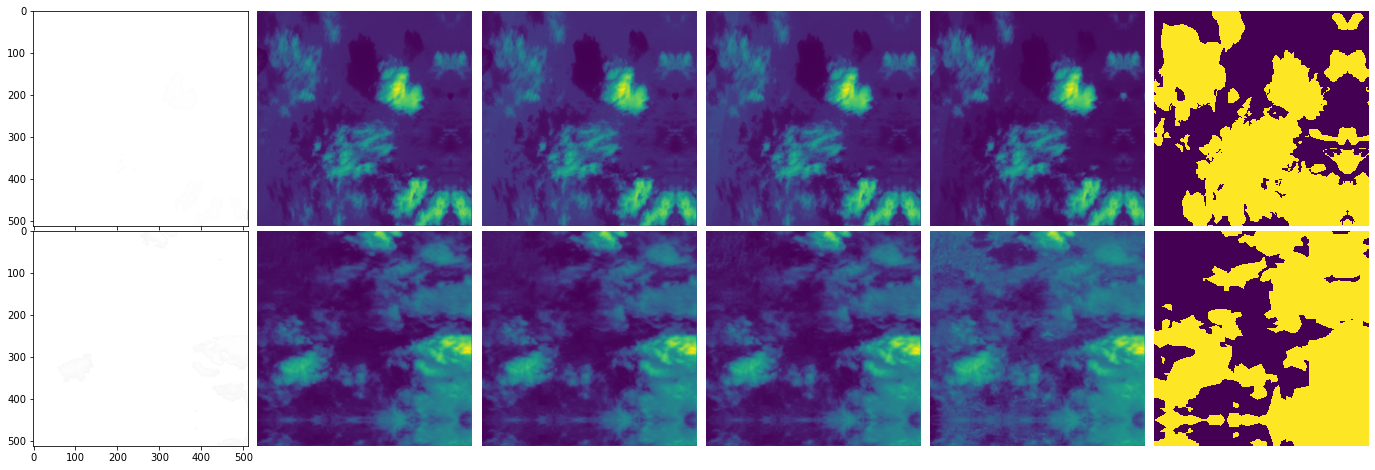

In [180]:

# train_transforms = A.Compose(aug)

vmins = [522., 648., 556., 534.]
vmaxs = [9600., 9312., 8928., 8488.]

dataset = CloudDataset(
    x_paths=train_meta,
    bands=params['bands_use'],
    y_paths=train_meta,
    cloudbank=None,
    transforms=train_transforms,
)


inds_plot = [0,1]

nbands = len(params['bands_use'])
nx = 2 + nbands
ny = len(inds_plot)
             
fig, ax = plt.subplots(ny, nx, figsize=(4*nx, 4*ny),
                        sharex=True, sharey=True, squeeze=False)

for i, ind in enumerate(inds_plot):

    item = dataset[ind]
    label = item['label']
    image = item['chip']

    print(np.min(image, axis=(1,2)), np.max(image, axis=(1,2)))
    # True color
    
    ax[i, 0].imshow(true_color_img(image))
    
    for ix in range(nbands):
        ax[i, ix+1].imshow(image[ix])#, vmin=vmins[ix], vmax=vmaxs[ix])
        ax[i, ix+1].axis('off')

    # Label panel
    ax[i, -1].imshow(label, vmin=0, vmax=1, interpolation='none')
    ax[i, -1].axis('off')

fig.subplots_adjust(hspace=0.025, wspace=0.025)